# KNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [2]:
%matplotlib inline

In [3]:
np.random.seed(1)

In [4]:
import os
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print("The code directory is located at", CODE_DIR)
sys.path.append(CODE_DIR)

The code directory is located at ./../../code


In [5]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries

In [6]:
from collections import defaultdict

## Read Train/Test Assignment

In [7]:
train_test_assignment = pd.read_csv("../../data/output/train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

## Extract Fingerprint Data for a Specific Floor

In [8]:
site_id = "5a0546857ecc773753327266"
floor_id = "B1"
base_data_dir = "../../data/wifi_fingerprint_manual/train/"

In [9]:
track_assignment = train_test_assignment[(train_test_assignment["site_id"] == site_id) & (train_test_assignment["floor_id"] == floor_id)]

In [10]:
train_tracks = track_assignment[track_assignment["dataset"] == "train"]
test_tracks = track_assignment[track_assignment["dataset"] == "test"]

In [11]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str) -> list[str]:
  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}_wifi_fingerprint.csv"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

In [12]:
train_files = get_track_filepaths(train_tracks, base_data_dir)
test_files = get_track_filepaths(test_tracks, base_data_dir)

* There are two approaches for testing the performance of `kNN`:
  1. Extract all fingerprints and put them into a single dataset. Then split the dataset into train and test datasets.
  2. Split tracks into train and test set.

* The first approach will cause unreliable results because some of the data in test dataset is leaked to the training step. This is obvious because of these fingerprints were collected from a track, in which waypoints were correlated.

* In this experiment, we use 80% of tracks for training models and 20% of tracks for testing model's performance.

In [13]:
print(f"The number of train files: {len(train_files)}")
print(f"The number of test files: {len(test_files)}")

The number of train files: 60
The number of test files: 49


In [14]:
def get_band(freq):
  d2400 = np.abs(freq - 2400)
  d5000 = np.abs(freq - 5000)
  band = np.zeros_like(freq)
  band[d2400 < d5000] = 2400
  band[d2400 >= d5000] = 5000
  return band


def extract_bssid_set(wifi_fingerprint_df_list: list[pd.DataFrame], min_times: int = 1000) -> set[str]:
  """
  Extract the set of bssid which occurs at least a specified number of times.

  Args:
    wifi_fingerprint_df_list: a list of 

  Refs:
    https://www.kaggle.com/code/devinanzelmo/wifi-features/notebook
  """
  bssid_sample_count = defaultdict(int)

  for df in wifi_fingerprint_df_list:
    df_bssid_sample_count = df["bssid"].value_counts().to_dict()
    for bssid, count in df_bssid_sample_count.items():
      bssid_sample_count[bssid] += count
  
  bssid_set = {k for k, v in bssid_sample_count.items() if v >= min_times}

  return bssid_set


def create_fingerprint_vector(group_data: pd.DataFrame,
                              bssid_vector: np.ndarray,
                              not_seen_rssi: float = -1000) -> np.ndarray:
  v = np.zeros_like(bssid_vector, dtype=np.float32) + not_seen_rssi

  for bssid, rssi in group_data[["bssid", "rssi"]].values:
    v[bssid_vector == bssid] = rssi

  return v


def extract_fingerprint_df(fingerprint_files, 
                           wifi_band=(2400, 5000), 
                           min_samples: int = 0,
                           not_seen_rssi: float = -1000,
                           max_scan_time_gap_ms: float = 2000):
  if isinstance(wifi_band, int):
    wifi_band = {wifi_band}

  wifi_fingerprint_df_list = [pd.read_csv(file) for file in fingerprint_files]

  # Adding frequency band
  for df in wifi_fingerprint_df_list:
    df["freq_band"] = get_band(df["freq"].values)

  wifi_fingerprint_fb_df_list = [
      df[df["freq_band"].isin(wifi_band) & (df["sys_ts"] - df["last_seen_ts"] <= max_scan_time_gap_ms)] for df in wifi_fingerprint_df_list
  ]

  bssid_set = extract_bssid_set(wifi_fingerprint_fb_df_list, min_times=min_samples)
  print(f"The number of BSSIDs with at least {min_samples} samples: {len(bssid_set)}")
  bssid_vector = np.array(list(bssid_set))

  fingerprint_tuples = []
  for df in tqdm(wifi_fingerprint_fb_df_list):
    for (sys_ts, x, y), group_data in df.groupby(["sys_ts", "x", "y"]):
      fingerprint_vector = create_fingerprint_vector(group_data,
                                                     bssid_vector,
                                                     not_seen_rssi=not_seen_rssi)
      fingerprint_tuples.append((x, y, fingerprint_vector))

  print(f"The number of fingerprints: {len(fingerprint_tuples)}")

  return pd.DataFrame(fingerprint_tuples, columns=["x", "y", "v"]), bssid_vector

In [15]:
train_fingerprint_df, train_bssid = extract_fingerprint_df(train_files, min_samples=0, not_seen_rssi=-100)

The number of BSSIDs with at least 0 samples: 1258


100%|██████████| 60/60 [00:02<00:00, 23.70it/s]

The number of fingerprints: 1504


In [16]:
test_fingerprint_df, test_bssid = extract_fingerprint_df(test_files, min_samples=0, not_seen_rssi=-100)

The number of BSSIDs with at least 0 samples: 1035


100%|██████████| 49/49 [00:00<00:00, 67.41it/s]

The number of fingerprints: 391


## Extracting Floormap Data

In [17]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

In [18]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

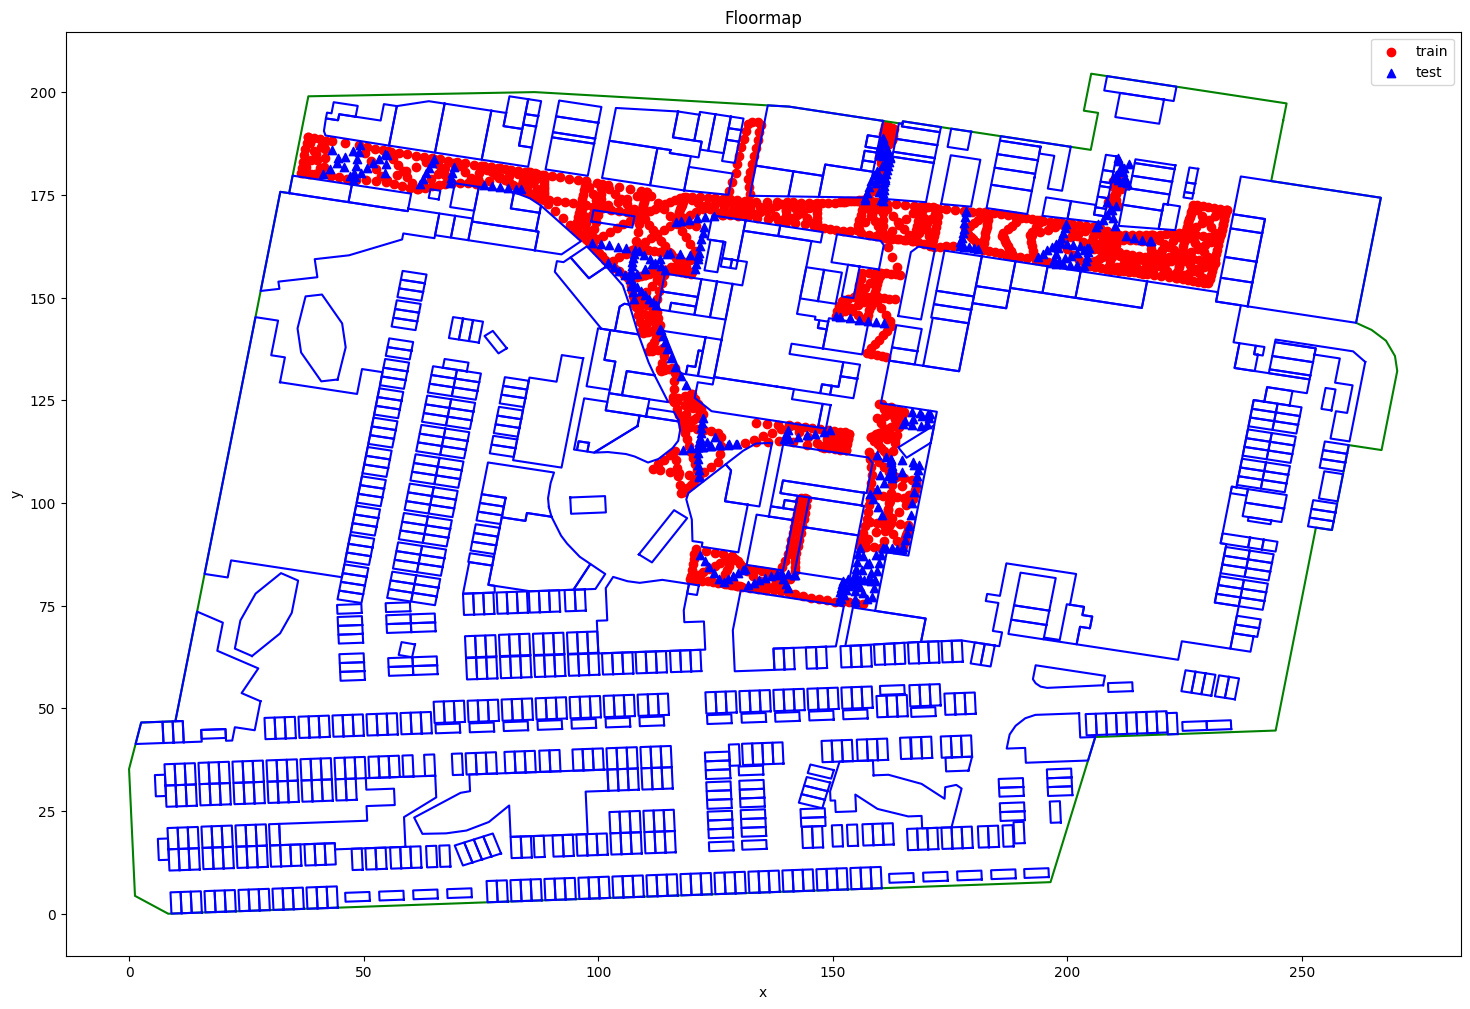

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

train_fingerprint_location = transform_func(train_fingerprint_df[["x",
                                                                  "y"]].values)
test_fingerprint_location = transform_func(test_fingerprint_df[["x",
                                                                "y"]].values)
ax.scatter(train_fingerprint_location[:, 0],
           train_fingerprint_location[:, 1],
           marker="o",
           color="red",
           label="train")
ax.scatter(test_fingerprint_location[:, 0],
           test_fingerprint_location[:, 1],
           marker="^",
           color="blue",
           label="test")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## KNN Regression

In [20]:
X_train = np.vstack(train_fingerprint_df["v"].values.tolist())
y_train = train_fingerprint_df[["x", "y"]].values

X_test = np.vstack(test_fingerprint_df["v"].values.tolist())
y_test = test_fingerprint_df[["x", "y"]].values

In [21]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [22]:
print(f"The number of train samples: {X_train.shape[0]}")
print(f"The number of test samples: {X_test.shape[0]}")

The number of train samples: 1504
The number of test samples: 391


* The first step is to translate the `X_test` in the test space into the associated vector in the train space.

In [23]:
def translator(test_bssid, train_bssid, unseen_rssi=-100):
  def c(X_test):
    X_test_translated = np.zeros((X_test.shape[0], train_bssid.shape[0])) + unseen_rssi
    for i, train_b in enumerate(train_bssid):
      indices = np.where(test_bssid == train_b)[0]

      if len(indices) == 1:
        X_test_translated[:, i] = X_test[:, indices[0]]
    
    return X_test_translated
  
  return c
    

In [24]:
train_test_translate = translator(test_bssid, train_bssid, unseen_rssi=-100)

In [25]:
X_test_translated = train_test_translate(X_test)

In [26]:
assert X_test_translated.shape[1] == X_train.shape[1]

* `kNN`: Finding the optimal k

In [27]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", leaf_size=17, algorithm="ball_tree")
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test_translated)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

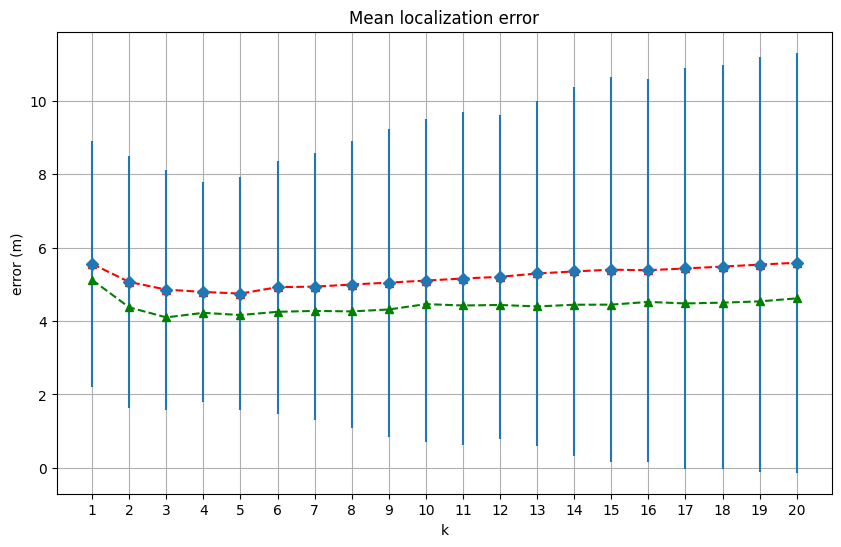

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()

plt.show()

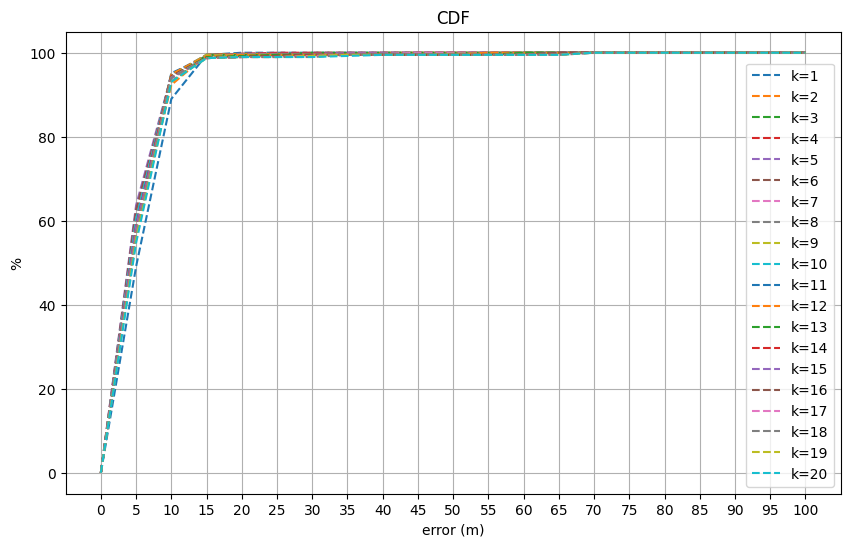

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = [i / 20 for i in range(51)]

for k, errors in zip(k_values, error_list):
  pdf, bins = np.histogram(errors, bins=20, range=(0, 100))
  pdf = pdf / errors.shape[0]
  error_cdf = np.cumsum(pdf)
  error_cdf = np.array([0, *error_cdf.tolist()])
  ax.plot(bins, error_cdf * 100, ls="--", label="k={}".format(k))

ax.set_xlabel("error (m)")
ax.set_ylabel("%")
ax.set_xticks(bins)
ax.set_title("CDF")

ax.grid()
ax.legend()

plt.show()

In [30]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=4.79m, std_error=2.98m


In [31]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=5.55m, std_error=3.35m


### `PCA` + `kNN`

In [32]:
from sklearn.preprocessing import MaxAbsScaler

In [33]:
scaler = MaxAbsScaler().fit(X_train)

In [34]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test_translated)

In [35]:
pca = PCA()
_ = pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_csum = np.cumsum(pca.explained_variance_ratio_)

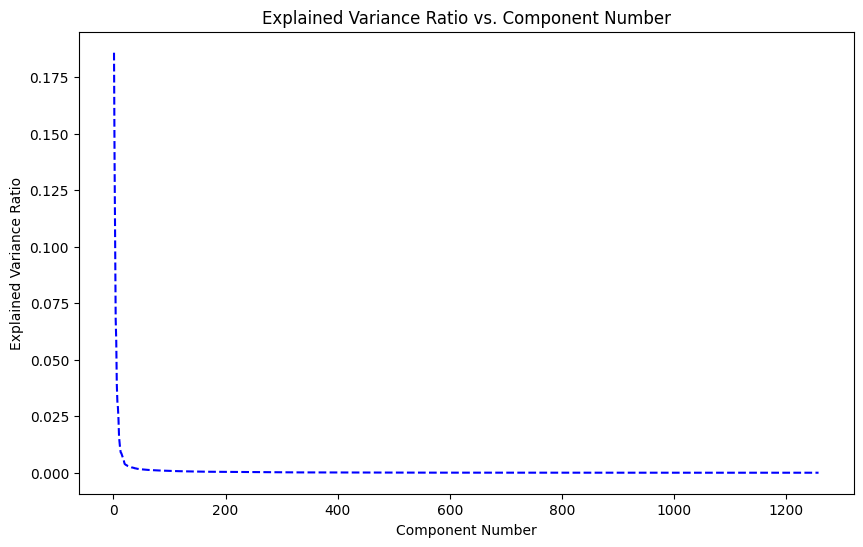

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(range(1, len(explained_variance_ratio) + 1), 
  explained_variance_ratio, ls="--", color="blue")
ax.set_xlabel("Component Number")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("Explained Variance Ratio vs. Component Number")

plt.show()

In [37]:
n_components = np.where(explained_variance_ratio_csum >= 0.9)[0][0] + 1
print(f"n_components={n_components}")

n_components=105


In [38]:
pca = PCA(n_components=n_components)
_ = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [39]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", leaf_size=17, algorithm="ball_tree")
  knn.fit(X_train_pca, y_train)
  y_pred = knn.predict(X_test_pca)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

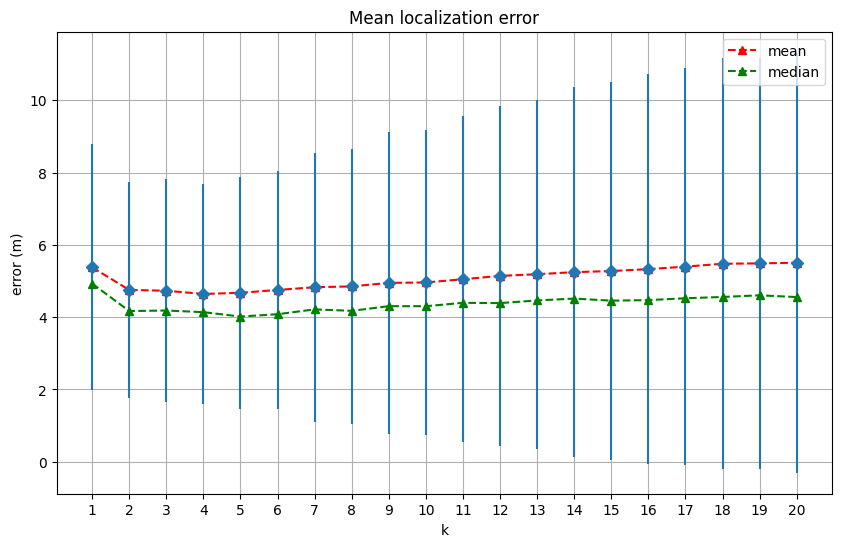

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()
ax.legend()

plt.show()

In [41]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=4.64m, std_error=3.04m


In [42]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=5.38m, std_error=3.40m


In [43]:
best_k_idx = 1
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=2, mean_error=4.75m, std_error=2.98m


In [44]:
best_k_idx = 2
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=3, mean_error=4.73m, std_error=3.08m


### `kNN` + `KernelPCA`

In [76]:
kernel_pca = KernelPCA(kernel="linear")
_ = kernel_pca.fit(X_train_scaled)

In [77]:
n_components = np.where(np.cumsum(kernel_pca.eigenvalues_ / kernel_pca.eigenvalues_.sum()) > 0.9)[0][0] + 1

In [78]:
n_components

106

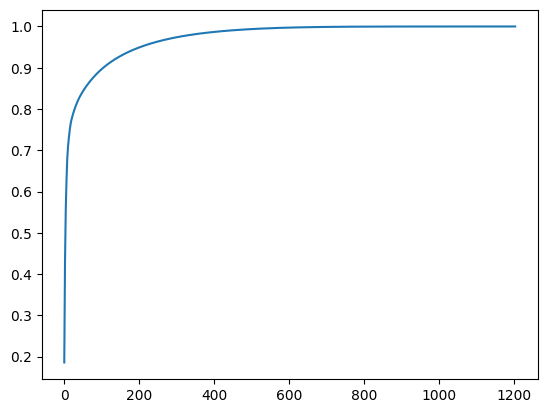

In [79]:
plt.plot(range(len(kernel_pca.eigenvalues_)), np.cumsum(kernel_pca.eigenvalues_ / kernel_pca.eigenvalues_.sum()))

In [81]:
kernel_pca = KernelPCA(n_components=n_components, kernel="linear")

_ = kernel_pca.fit(X_train_scaled)
X_train_kpca = kernel_pca.transform(X_train_scaled)
X_test_kpca = kernel_pca.transform(X_test_scaled)

In [82]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", leaf_size=17, algorithm="ball_tree")
  knn.fit(X_train_kpca, y_train)
  y_pred = knn.predict(X_test_kpca)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

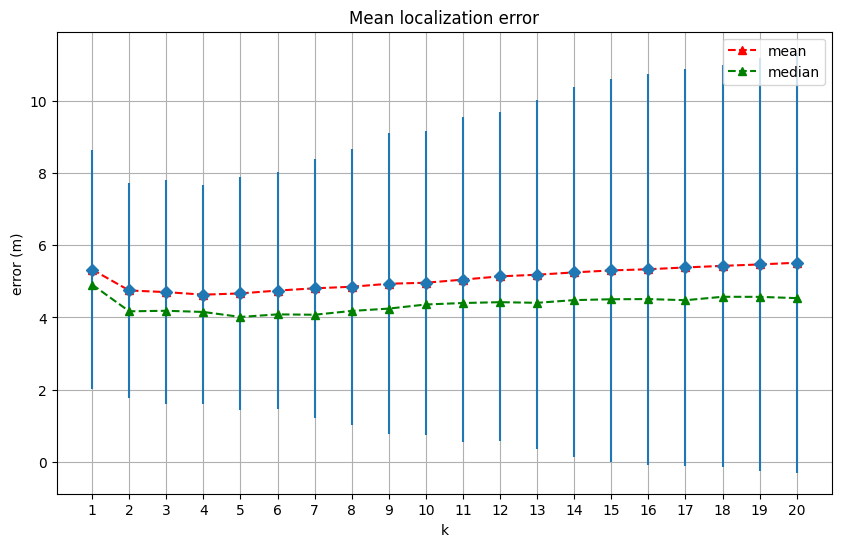

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()
ax.legend()

plt.show()

In [84]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=4.63m, std_error=3.03m


In [85]:
best_k_idx = 1
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=2, mean_error=4.75m, std_error=2.97m


In [86]:
best_k_idx = 2
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=3, mean_error=4.70m, std_error=3.09m


In [87]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=5.33m, std_error=3.29m
